In [157]:
# PARTE 1 — IMPORTS Y CONFIG
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
%matplotlib inline

In [158]:
# PARTE 2 — CARGA DE DATOS (CSV o Excel)
data_path = Path("Facebook_Marketplace_data.csv")  # ajusta si tu archivo tiene otro nombre/extensión
if data_path.suffix.lower() in [".xlsx", ".xls"]:
    df = pd.read_excel(data_path)
else:
    df = pd.read_csv(data_path)
print("Dimensiones:", df.shape)
display(df.head())
print("Columnas:", df.columns.tolist())


Dimensiones: (7050, 16)


,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


Columnas: ['status_id', 'status_type', 'status_published', 'num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'Column1', 'Column2', 'Column3', 'Column4']


In [159]:
# PARTE 3 — PREPROCESAMIENTO (limpieza + nuevas columnas útiles)
df_clean = df.copy()

# 3.1 — eliminar columnas basura/duplicadas
drop_unn = [c for c in df_clean.columns if str(c).startswith("Unnamed")]
if drop_unn: df_clean.drop(columns=drop_unn, inplace=True)
df_clean.drop_duplicates(inplace=True)

# 3.2 — normalizar strings
for c in ["title","name","description"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].astype(str).str.strip()

# 3.3 — precio → price_num (soporta "$1,299 MXN", "1299,99", "free")
def parse_price(x):
    s = str(x).lower()
    if any(k in s for k in ["gratis","free","sin costo"]): 
        return 0.0
    t = re.sub(r"[^0-9.,-]", "", s)
    if "," in t and "." in t: t = t.replace(",", "")  # coma miles
    else: t = t.replace(",", ".")                      # coma decimal
    if t.count(".") > 1:  # dejar un solo punto decimal
        i = t.find("."); t = t[:i+1] + t[i+1:].replace(".","")
    try: return float(t)
    except: return np.nan

if "price_num" not in df_clean.columns:
    price_src = next((c for c in df_clean.columns if re.search(r"price", str(c), re.I)), None)
    if price_src: df_clean["price_num"] = df_clean[price_src].apply(parse_price)

# 3.4 — señales de engagement (si existen)
eng_cols = [c for c in df_clean.columns if re.search(r"(view|comment|like|interest|save|message|share)", str(c), re.I)]
if eng_cols:
    df_clean["engagement"] = df_clean[eng_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)

# 3.5 — longitudes de texto
if "title" in df_clean.columns:
    df_clean["title_len"] = df_clean["title"].fillna("").astype(str).str.len()
elif "name" in df_clean.columns:
    df_clean["title_len"] = df_clean["name"].fillna("").astype(str).str.len()
if "description" in df_clean.columns:
    df_clean["desc_len"] = df_clean["description"].fillna("").astype(str).str.len()

# 3.6 — fecha → edad y componentes
date_col = next((c for c in ["created_time","posted_time","publish_time","date_posted","created_at","published_time","status_published"] if c in df_clean.columns), None)
if date_col:
    df_clean["posted_at"] = pd.to_datetime(df_clean[date_col], errors="coerce")
    now = pd.Timestamp.now()
    df_clean["age_days"] = (now - df_clean["posted_at"]).dt.days
    df_clean["year"]  = df_clean["posted_at"].dt.year
    df_clean["month"] = df_clean["posted_at"].dt.month
    df_clean["hour"]  = df_clean["posted_at"].dt.hour

# 3.7 — variables derivadas útiles
if "price_num" in df_clean.columns:
    df_clean["log_price"] = np.log1p(df_clean["price_num"])
    if "desc_len" in df_clean.columns:
        df_clean["price_per_char"] = df_clean["price_num"] / (df_clean["desc_len"] + 1)

display(df_clean.head())


,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4,engagement,posted_at,age_days,year,month,hour
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN,1206,2018-04-22 06:00:00,2706,2018,4,6
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN,150,2018-04-21 22:45:00,2706,2018,4,22
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN,497,2018-04-21 06:17:00,2707,2018,4,6
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN,111,2018-04-21 02:29:00,2707,2018,4,2
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN,204,2018-04-18 03:22:00,2710,2018,4,3


In [160]:
# PARTE 4 — DIAGNÓSTICO Y ELIMINACIÓN DE VARIABLES POCO ÚTILES (con justificación)
reasons = {}

# 4.1 — quitar columnas con >98% NaN
too_missing = [c for c in df_clean.columns if df_clean[c].isna().mean() > 0.98]
for c in too_missing: reasons[c] = "Eliminada: >98% valores faltantes"
df_clean.drop(columns=too_missing, inplace=True, errors="ignore")

# 4.2 — quitar numéricas con varianza ~0 (constantes)
num_cols_all = df_clean.select_dtypes(include=[np.number]).columns
zero_var = [c for c in num_cols_all if df_clean[c].nunique(dropna=True) <= 1]
for c in zero_var: reasons[c] = "Eliminada: varianza ~0 (constante)"
df_clean.drop(columns=zero_var, inplace=True, errors="ignore")

# 4.3 — quitar columnas claramente identificadores/URLs
id_like = [c for c in df_clean.columns if re.search(r"(id$|^id_|_id$|url|link)", str(c), re.I)]
for c in id_like: reasons[c] = "Eliminada: identificador/URL (no informativa para análisis estadístico)"
df_clean.drop(columns=id_like, inplace=True, errors="ignore")

print("Total variables eliminadas:", len(reasons))
for k,v in reasons.items():
    print(f"- {k}: {v}")

print("\nDimensiones tras limpieza:", df_clean.shape)


Total variables eliminadas: 5
- Column1: Eliminada: >98% valores faltantes
- Column2: Eliminada: >98% valores faltantes
- Column3: Eliminada: >98% valores faltantes
- Column4: Eliminada: >98% valores faltantes
- status_id: Eliminada: identificador/URL (no informativa para análisis estadístico)

Dimensiones tras limpieza: (7050, 17)


In [161]:
# PARTE 5 — SELECCIÓN DE VARIABLES PARA ANÁLISIS (numéricas y categórica principal)
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_col = next((c for c in ["category","subcategory","item_category","product_category","condition","section","city","state"]
                if c in df_clean.columns and df_clean[c].nunique(dropna=True) >= 2 and df_clean[c].nunique(dropna=True) <= 40), None)
if cat_col is None:
    # cualquier categórica razonable
    cat_candidates = [c for c in df_clean.columns if df_clean[c].dtype.name in ["category","object"] and 2 <= df_clean[c].nunique(dropna=True) <= 40]
    cat_col = cat_candidates[0] if cat_candidates else None

print("Numéricas:", num_cols[:15], ("..." if len(num_cols)>15 else ""))
print("Categórica elegida:", cat_col)


Numéricas: ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'engagement', 'age_days', 'year', 'month', 'hour'] 
Categórica elegida: status_type


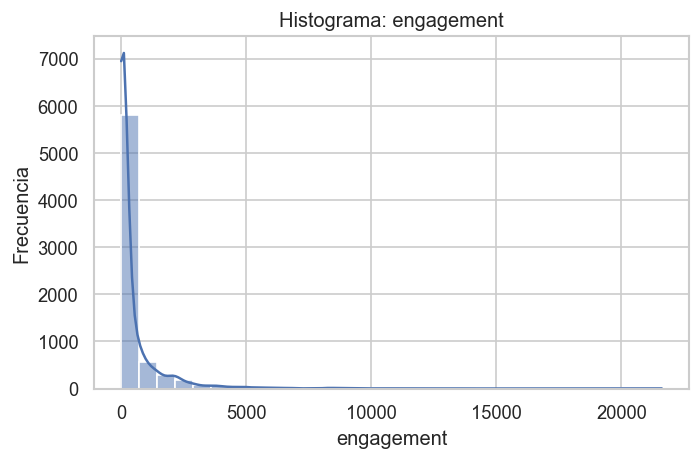

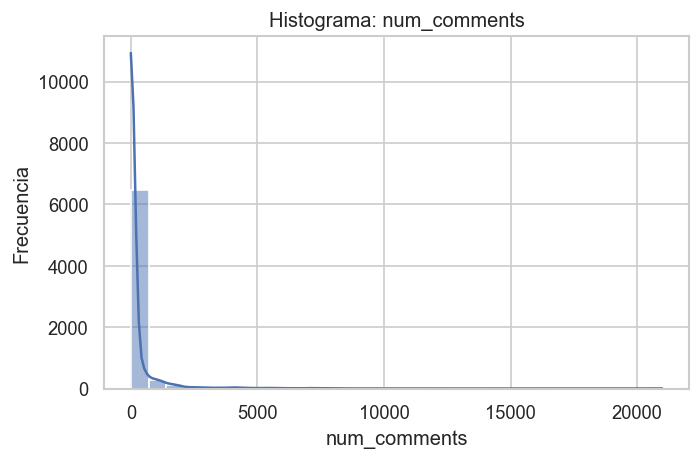

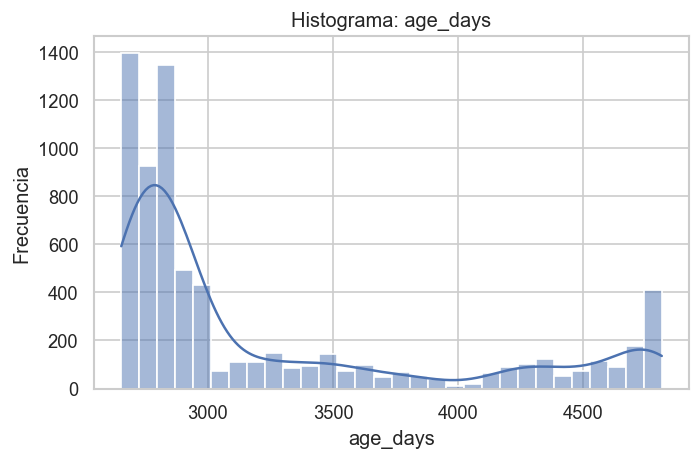

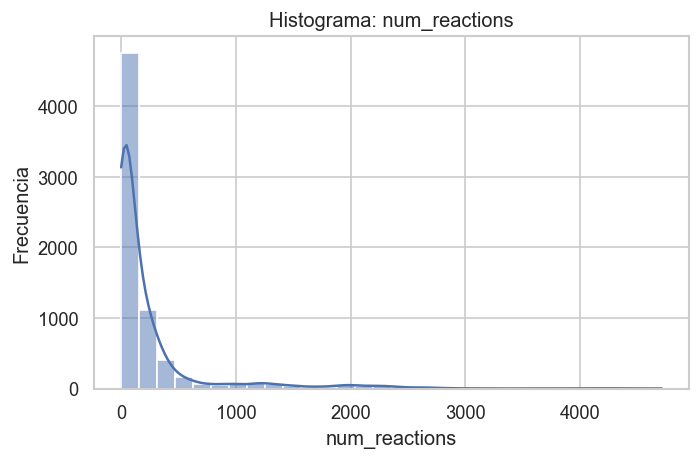

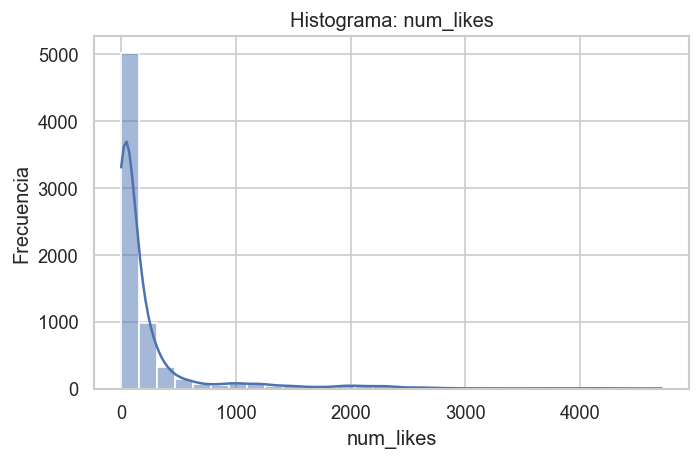

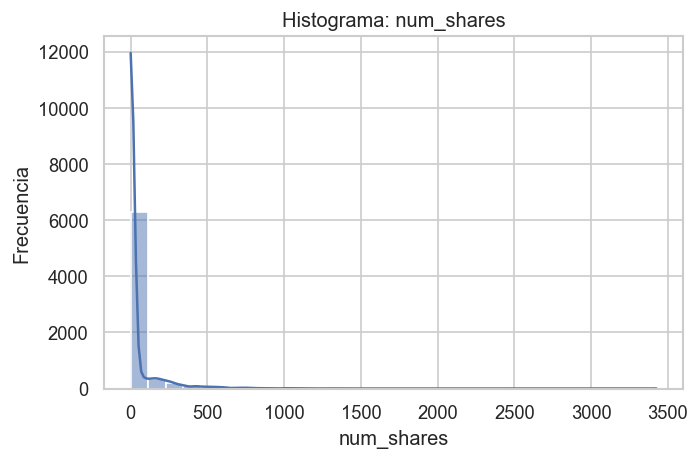

In [162]:
# PARTE 6 — HISTOGRAMAS (selección automática de hasta 6 variables con mayor varianza)
var_order = df_clean[num_cols].var(numeric_only=True).sort_values(ascending=False)
hist_vars = var_order.index[:6].tolist()
for col in hist_vars:
    plt.figure(figsize=(6,4))
    sns.histplot(df_clean[col].dropna(), bins=30, kde=True)
    plt.title(f"Histograma: {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.tight_layout(); plt.show()


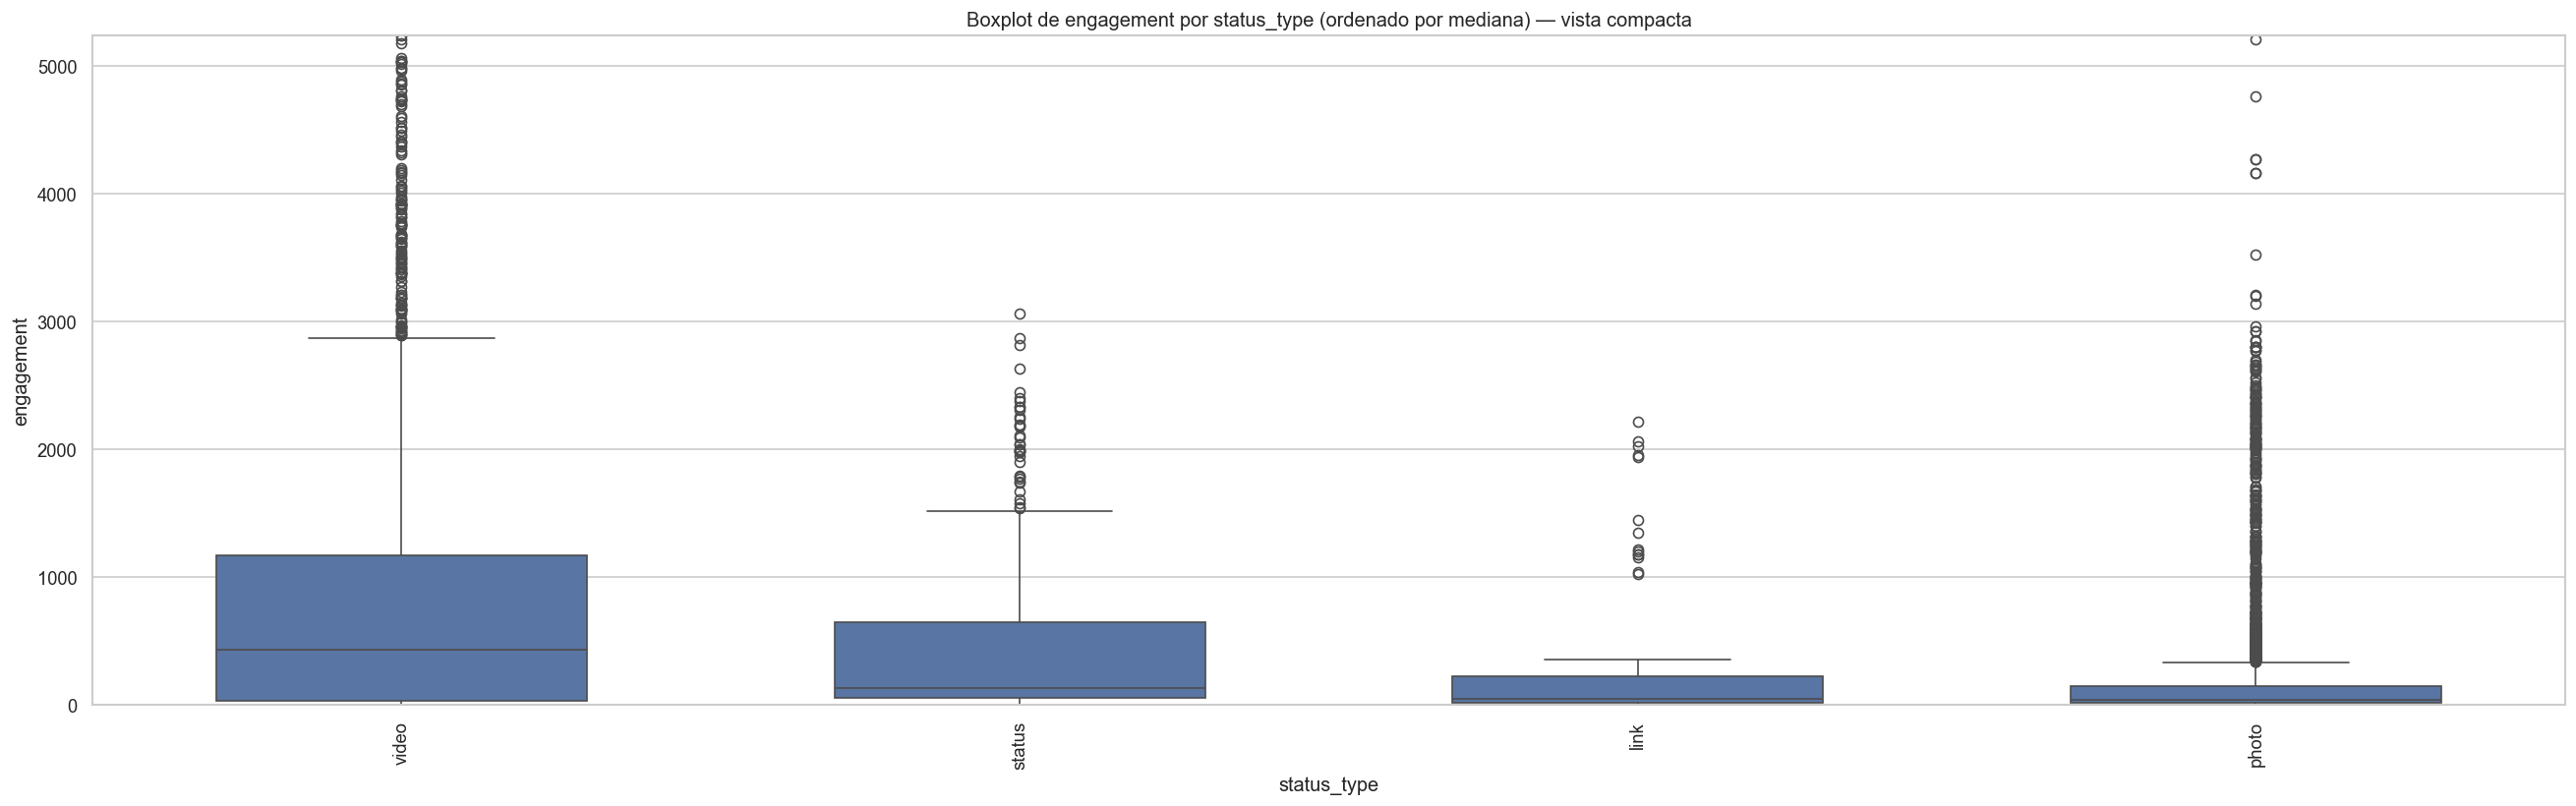

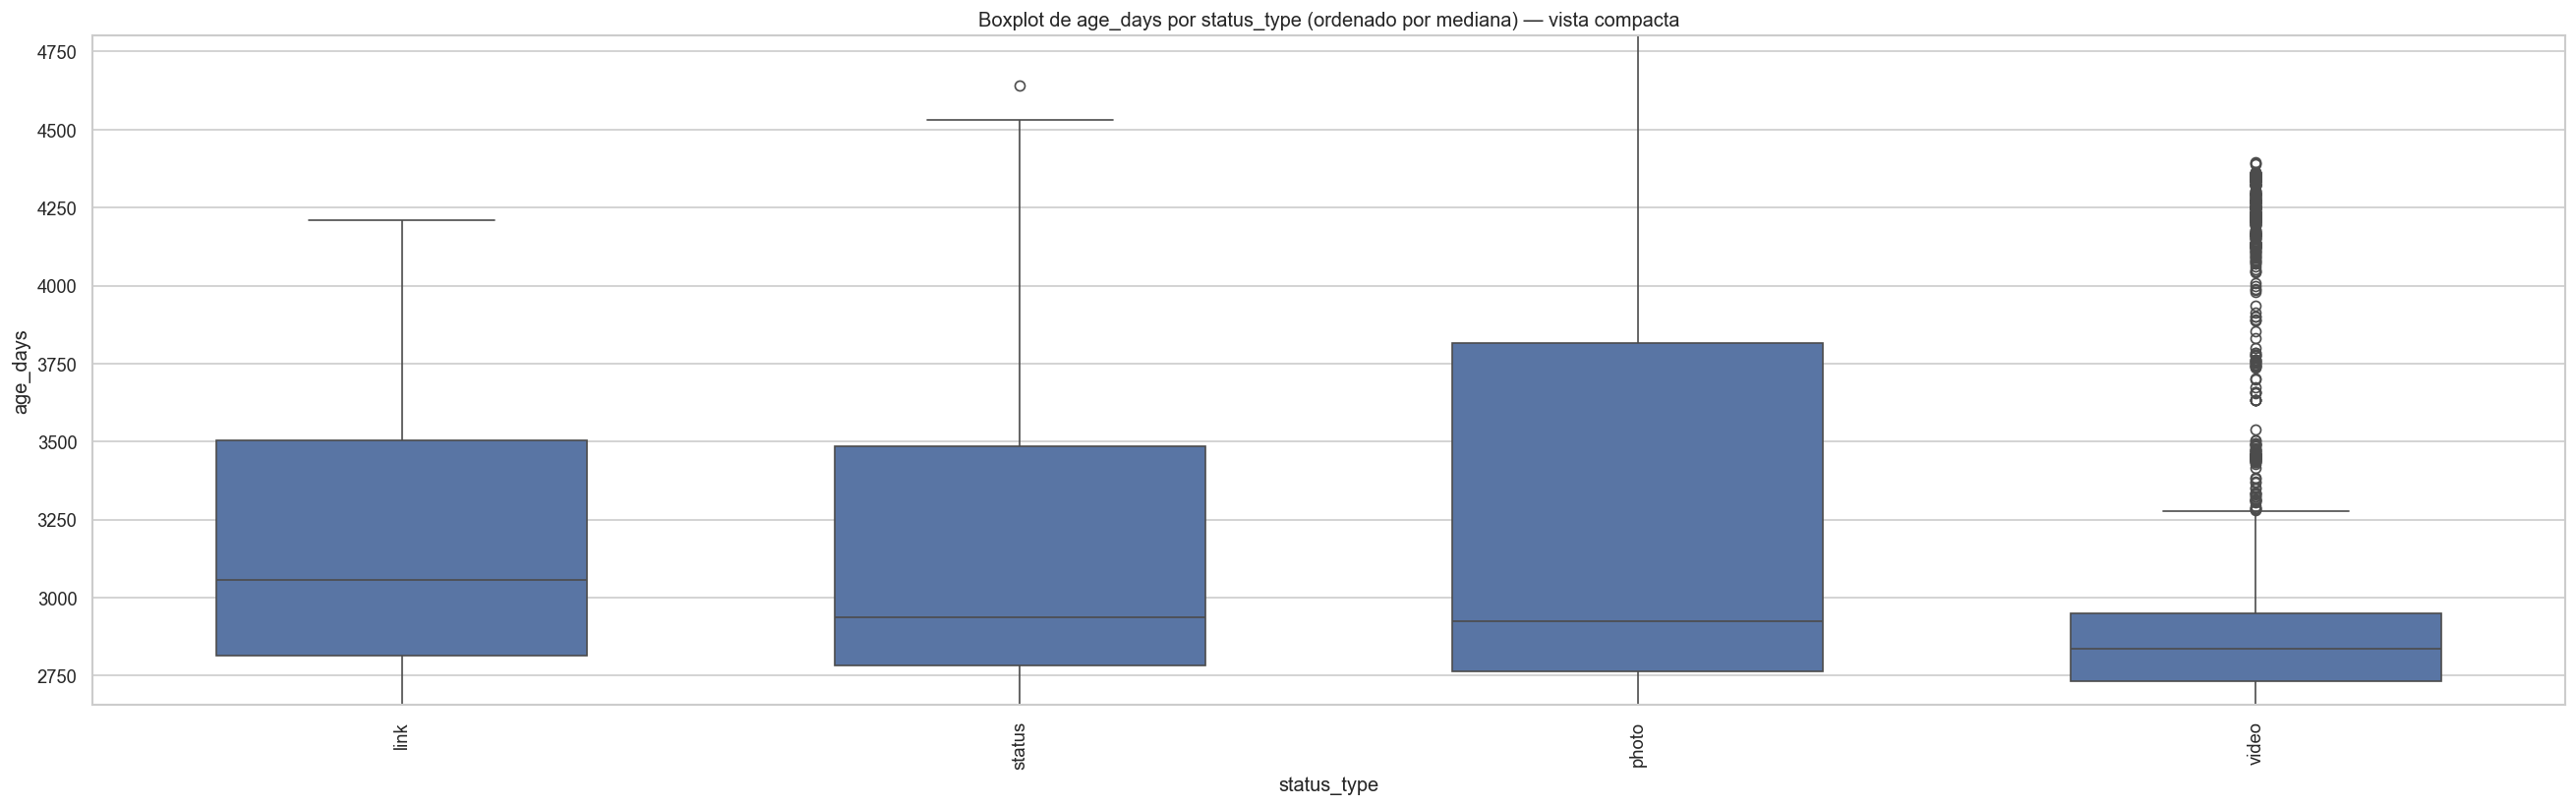

In [163]:
# PARTE 7 — BOXPLOTS
def order_by_median(dfm, x_col, y_col):
    med = dfm[[x_col, y_col]].dropna().groupby(x_col)[y_col].median().sort_values(ascending=False)
    return med.index

# Elegir categórica principal; si no existe, crear una por cuantiles de la métrica base
cat = cat_col if 'cat_col' in globals() else None
y_base = "price_num" if "price_num" in df_clean.columns else (
    df_clean.select_dtypes(include=[np.number]).columns[:1].tolist()[0] if len(df_clean.select_dtypes(include=[np.number]).columns) else None
)
if cat is None and y_base is not None:
    q = pd.qcut(df_clean[y_base].dropna(), q=4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
    df_clean["cat_auto"] = pd.NA
    df_clean.loc[q.index, "cat_auto"] = q.astype(str)
    cat = "cat_auto"

# Targets para graficar (dos boxplots por categoría) + uno global (caja y bigotes)
targets = []
for c in ["price_num", "engagement", "log_price", "title_len", "desc_len", "age_days"]:
    if c in df_clean.columns and c not in targets:
        targets.append(c)
targets = targets[:2] if len(targets) >= 2 else targets

# ==== BOXPLOTS POR CATEGORÍA (al estilo Spotify, ordenado por mediana) ====
for y in targets:
    if cat and df_clean[y].notna().sum() >= 10:
        order = order_by_median(df_clean, cat, y)
        plt.figure(figsize=(22,7))
        sns.boxplot(data=df_clean, x=cat, y=y, order=order, showfliers=True, width=0.6, linewidth=1)
        # Vista compacta por percentiles (no modifica datos, solo la visualización)
        low, high = df_clean[y].quantile([0.01, 0.99])
        if np.isfinite(low) and np.isfinite(high) and low < high:
            plt.ylim(bottom=low, top=high)
        plt.xticks(rotation=90)
        plt.title(f"Boxplot de {y} por {cat} (ordenado por mediana) — vista compacta")
        plt.xlabel(cat); plt.ylabel(y)
        plt.tight_layout(); plt.show()

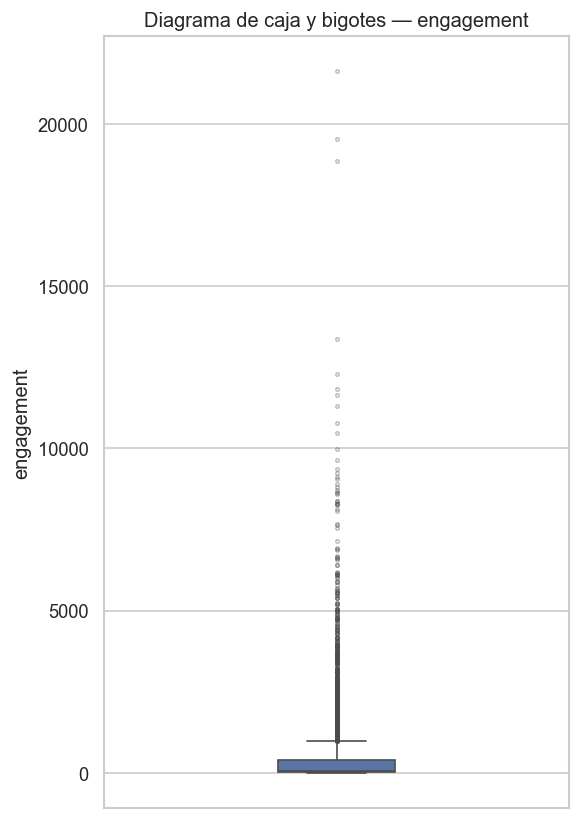

In [164]:
#7.1 DIAGRAMA DE CAJA Y BIGOTES 
dfb = df_clean if 'df_clean' in globals() else df  # usa el DF que ya cargaste

preferidas = [c for c in ["price_num","engagement","title_len","desc_len","age_days","log_price"] if c in dfb.columns]
num_cols = dfb.select_dtypes(include=[np.number]).columns.tolist()

# 1) elige una columna: prioridad preferidas → mayor varianza
candidatas = preferidas if preferidas else num_cols
candidatas = [c for c in candidatas if dfb[c].dropna().nunique() >= 2]  # con variación
if not candidatas:
    raise ValueError("No encontré columnas numéricas con variación para el boxplot.")

# si no usamos preferidas, escoger por varianza
if not preferidas:
    var_order = dfb[candidatas].var(numeric_only=True).sort_values(ascending=False).index.tolist()
    y = var_order[0]
else:
    y = candidatas[0]

s = pd.to_numeric(dfb[y], errors="coerce").dropna()

plt.figure(figsize=(5,7))
sns.boxplot(y=s, showfliers=True, width=0.25, linewidth=1,
            flierprops=dict(marker="o", markersize=2, alpha=0.35))
plt.ylabel(y)
plt.title(f"Diagrama de caja y bigotes — {y}")
plt.tight_layout(); plt.show()

Variables en heatmap: ['engagement', 'age_days', 'hour', 'month', 'year']


,engagement,age_days,hour,month,year
engagement,1.000000,-0.098342,0.004578,-0.030337,0.100842
age_days,-0.098342,1.000000,0.036564,0.078707,-0.988047
hour,0.004578,0.036564,1.000000,-0.038708,-0.030198
month,-0.030337,0.078707,-0.038708,1.000000,-0.230947
year,0.100842,-0.988047,-0.030198,-0.230947,1.000000


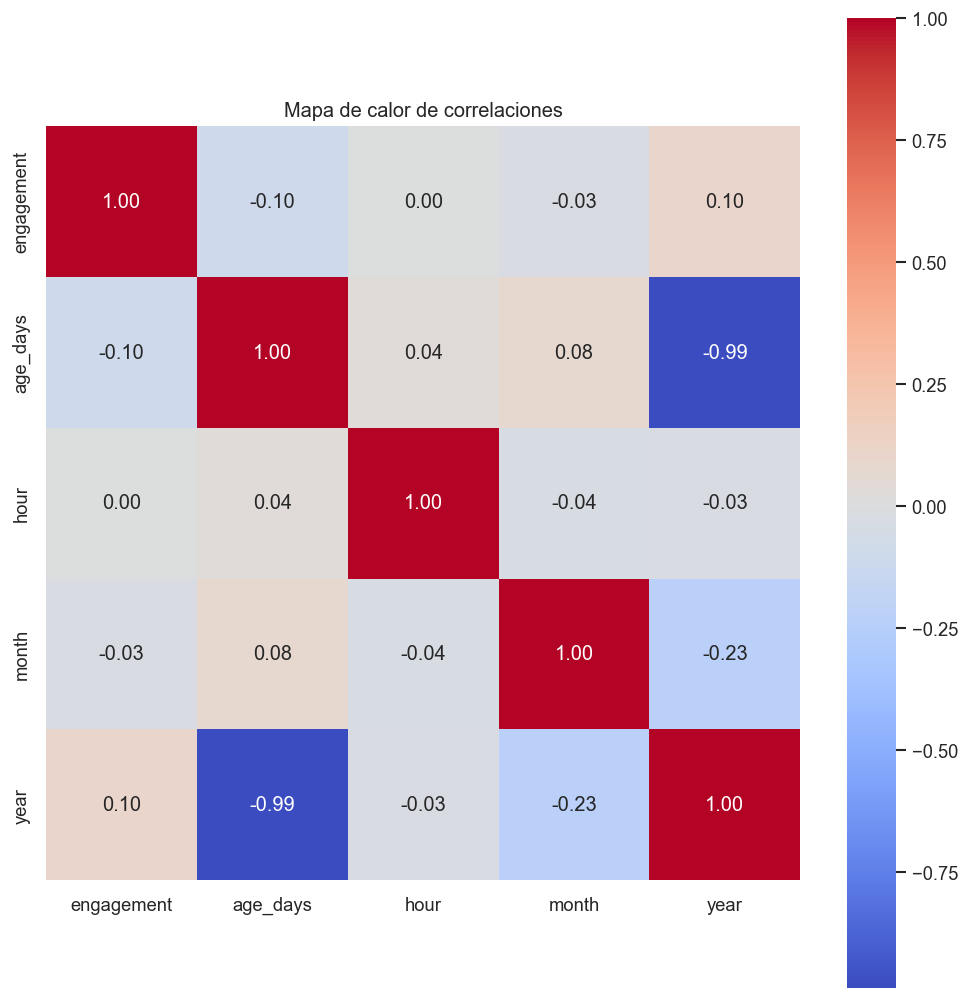

In [165]:
# PARTE 8 — HEATMAP DE CORRELACIONES (asegurar ≥5 variables)
wanted = ["price_num","engagement","title_len","desc_len","age_days","log_price","price_per_char","hour","month","year"]
vars_corr = [c for c in wanted if c in df_clean.columns]

# completar con otras numéricas hasta ≥5
if len(vars_corr) < 5:
    extras = [c for c in num_cols if c not in vars_corr]
    extras = df_clean[extras].var(numeric_only=True).sort_values(ascending=False).index.tolist()
    vars_corr += [c for c in extras if c not in vars_corr][: max(0, 5 - len(vars_corr))]

# filtrar columnas con datos suficientes
vars_corr = [c for c in vars_corr if df_clean[c].notna().sum() >= 10]
print("Variables en heatmap:", vars_corr)

corr = df_clean[vars_corr].corr()
display(corr)

plt.figure(figsize=(1.1*len(vars_corr)+3, 1.1*len(vars_corr)+3))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Mapa de calor de correlaciones")
plt.tight_layout(); plt.show()


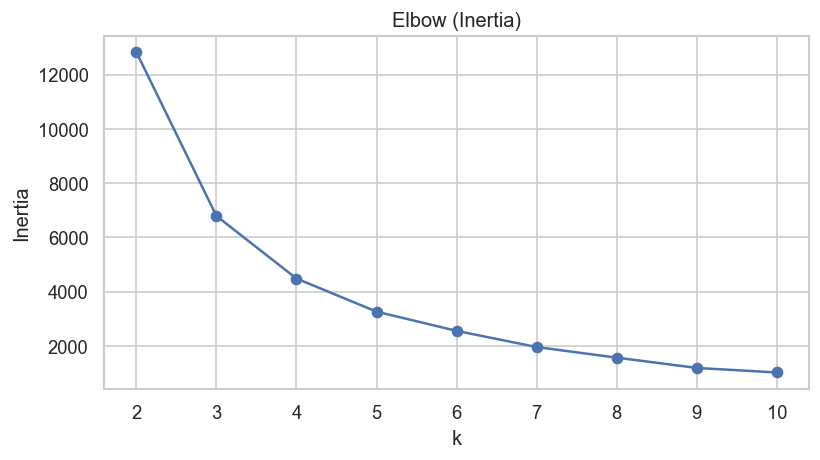

Usaremos k=4 (según lo solicitado).


In [166]:
# PARTE 9 — ELECCIÓN DE k (gráfica del codo + silueta)  — diagnóstico
features_for_clustering = [c for c in ["price_num","engagement","title_len","desc_len","age_days","log_price","price_per_char"] if c in df_clean.columns]
if len(features_for_clustering) < 3:
    extras = [c for c in df_clean.select_dtypes(include=[np.number]).columns if c not in features_for_clustering]
    extras = df_clean[extras].var(numeric_only=True).sort_values(ascending=False).index.tolist()
    features_for_clustering += extras[: max(0, 3 - len(features_for_clustering))]

X = df_clean[features_for_clustering].copy()

pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
X_proc = pipe.fit_transform(X)

Ks = range(2, 11)
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_proc)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(list(Ks), inertias, marker="o")
plt.title("Elbow (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.xticks(list(Ks))
plt.tight_layout(); plt.show()

print("Usaremos k=4 (según lo solicitado).")


In [167]:
# PARTE 10 — K-MEANS CON k=4 Y CENTROS (en escala original)
k = 4

km = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = km.fit_predict(X_proc)

# centros en escala estandarizada → devolver a escala original
centers_std = km.cluster_centers_
centers_orig = pipe.named_steps["scale"].inverse_transform(centers_std)
centers_df = pd.DataFrame(centers_orig, columns=features_for_clustering)
centers_df.index = [f"cluster_{i}" for i in range(k)]

df_clusters = df_clean.copy()
df_clusters["cluster"] = labels

print("Centros de k-means (escala original):")
display(centers_df.round(3))

print("Distribución de clusters:")
display(df_clusters["cluster"].value_counts().to_frame("count"))


Centros de k-means (escala original):


,engagement,age_days,num_comments
cluster_0,187.233,2892.270,54.812
cluster_1,7030.574,2845.614,6066.228
cluster_2,191.219,4514.750,8.970
cluster_3,2249.635,3047.434,1040.352


Distribución de clusters:


,count
cluster,
0,4907
2,1381
3,661
1,101


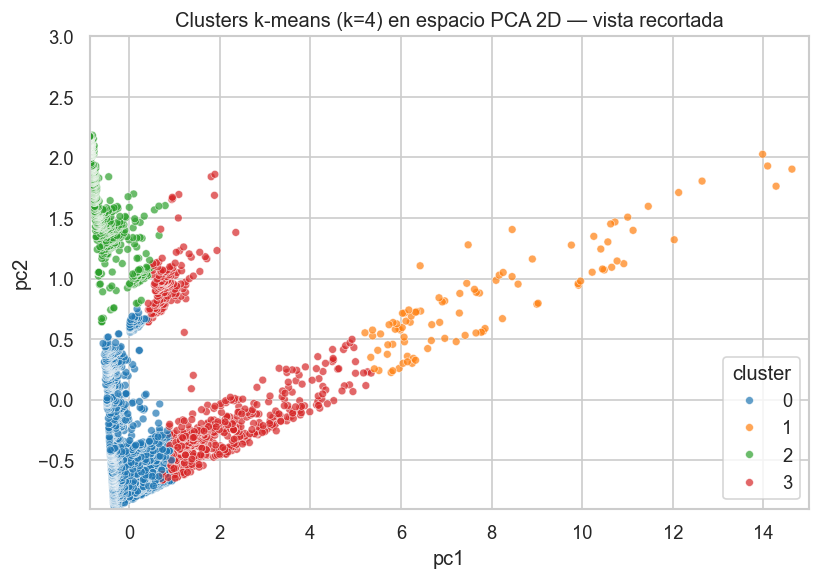

In [168]:
# PARTE 11 — VISUALIZACIÓN DE CLUSTERS
from sklearn.decomposition import PCA

# PCA en 2D sobre las features ya escaladas (X_proc) y etiquetas de k-means (labels)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_proc)
plot_df = pd.DataFrame(coords, columns=["pc1", "pc2"])
plot_df["cluster"] = labels

plt.figure(figsize=(7,5))
sns.scatterplot(data=plot_df, x="pc1", y="pc2", hue="cluster",
                palette="tab10", s=22, alpha=0.7)

# Recorte fijo de ejes para que la figura quede compacta 
plt.xlim(left=plot_df["pc1"].min(), right=15)
plt.ylim(bottom=plot_df["pc2"].min(), top=3)

plt.title("Clusters k-means (k=4) en espacio PCA 2D — vista recortada")
plt.tight_layout()
plt.show()



In [169]:
# PARTE 12 — RESUMEN DE DECISIONES (variables eliminadas / usadas)
print("Variables eliminadas y motivo (si hubo):")
try:
    for k,v in reasons.items():
        print(f"- {k}: {v}")
except NameError:
    print("No se eliminaron variables por las reglas definidas.")

print("\nVariables usadas para clustering:")
print(features_for_clustering)


Variables eliminadas y motivo (si hubo):
- Column1: Eliminada: >98% valores faltantes
- Column2: Eliminada: >98% valores faltantes
- Column3: Eliminada: >98% valores faltantes
- Column4: Eliminada: >98% valores faltantes
- status_id: Eliminada: identificador/URL (no informativa para análisis estadístico)

Variables usadas para clustering:
['engagement', 'age_days', 'num_comments']


*Mapa de calor y boxplots*
¿Hay alguna variable que no aporta información?

"si las variables son las columnas 1 a 4 y el ID colocado por el data set"
Si tuvieras que eliminar variables ¿cuáles eliminarias y porque? 

"Estas variables antes mencionadas porque no aportan datos relevantes al estudio"
¿Existen variables que tengan datos extraños? 

"Únicamente las columnas de 1 a 4 con los datos no asignados"
Si comparas las variables ¿todas están en rangos similares? 

"si están en rangos similares"
¿Crees que esto afecte? 

"Si estuvieran en rangos muy diferentes podría afectar a los análisis posteriores"
¿Puedes encontrar grupos que se parezcan? 

"Si, en las columnas 1 a 4 se pueden encontrar grupos similares, en las fechas de publicación y hace tantos días se publicó"
¿Qué grupos son estos? 

"Son las variables con datos similares entre sí"

*Patrones con k-means*
¿Crees que estos centros puedan ser representativos de los datos? 
"Si es representativos"
¿Por qué? 
"Porque los clusters están bien definidos visualmente y algunos muy compactos"
¿Cómo obtuviste el valor de k a usar? 
"El código procesa las primeras 2 variables específicas, después de ello procesa los datos metiendo valores faltantes usando la mediana y calcula la inercia para distintos valores de K, después de ello grafica la curva del codo, se selecciona k=3 para este caso y obtener 4 clusters"
¿Los centros serían más representativos si usaras un valor más alto o lo serían si fuera más bajo?
"Si se usara un valor k más alto se podría dividir uno de los clusters en dos subgrupos uno más alejado y otro mas cercano al centro por lo que podría mejorar la representatividad, por otro lado para un k más bajo se tendría menor complejidad aunque empeoraría la representatividad"
¿Qué pasaría con los centros si tuviéramos muchos outliers en el análisis de cajas y bigotes? 
"Los outliers podrían desplazar los centros de los clusters, haciendo que sean menos representativos de la mayoría de los datos"
¿Qué puedes decir de los datos basándose en los centros? 
"Los centros reflejan las características promedio de cada cluster, lo que puede ayudar a entender las diferencias entre los grupos"